# hillmaker plotting demo

This is just the next iteration. Totally open to ideas for improvements. Goal was to create basic daily and weekly plotting functions and associated scenario methods. Also tried to improve the customizability of the plots by the user.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from pandas import Timestamp
from typing import Tuple, List
import numpy as np

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from cycler import cycler
from IPython.display import Image

# Import seaborn
#import seaborn as sns

import hillmaker as hm
from hillmaker.hmlib import pctile_field_name
from hillmaker.plotting import make_week_hill_plot, make_daily_hill_plot

In [3]:
%matplotlib inline

## Matplotlib styling review

What does a plot look like with the default style.

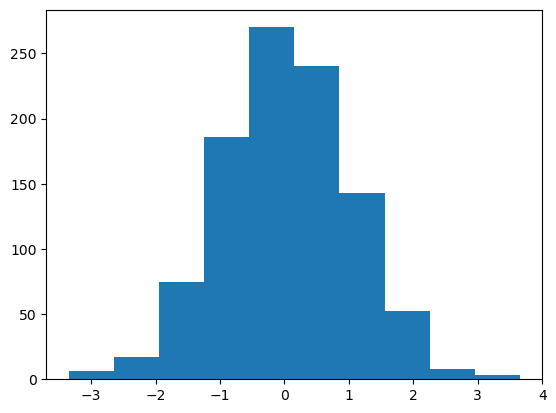

In [4]:
plt.hist(np.random.randn(1000));

Make a copy of the current `rcParams`. These are the defaults for matplotlib since I haven't set any style related things.

In [5]:
jupyter_default = plt.rcParams.copy()



There's several hundred so I commented out the following.

In [6]:
#jupyter_default

`jupyter_default` is a dictionary.

In [7]:
jupyter_default['axes.edgecolor']

'black'

In [8]:
jupyter_default['axes.grid']

False

Individual properties of the underlying style can be changed like this.

In [9]:
plt.rcParams['axes.grid'] = True

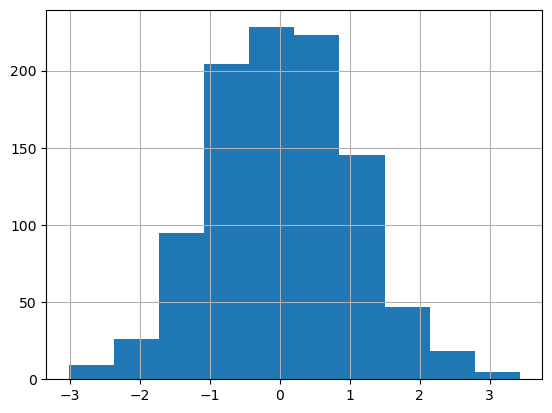

In [10]:
plt.hist(np.random.randn(1000));
# reset to to default
plt.rcParams['axes.grid'] = False

There's an `rc` convenience function for setting a bunch of properties for a *group*. The following example (from JVP's Python book) shows how to also use the color cycler to change colors of lines (and the bars in a histogram).

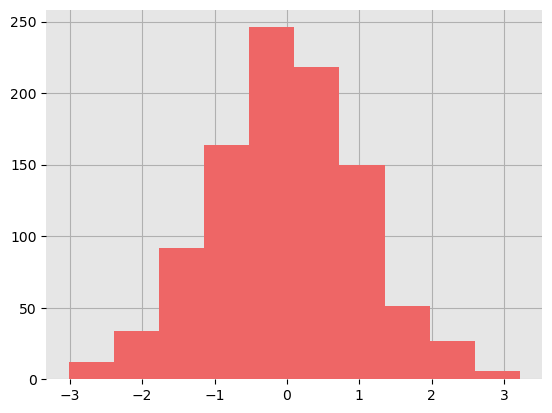

In [11]:
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)

plt.hist(np.random.randn(1000));

In [12]:
plt.rcParams['axes.grid']

True

Let's undo all those changes and get things back to default style. I think both of the following accomplish the same thing.

```
plt.rcdefaults()
# The following also seems to do the same thing
plt.style.use('default')


```

In [13]:
#plt.style.use('default')
plt.rcdefaults()
plt.rcParams['axes.grid']

False

We can use a context manager to temporarily get or set plot style related parameters.

In [14]:
# Get a few properties for ggplot style
with plt.style.context('ggplot'):
    print(f'ggplot axes.grid = {plt.rcParams["axes.grid"]}')
    print(f'ggplot axes.edgecolor = {plt.rcParams["axes.edgecolor"]}')
    
# Now print same properties for default style
print(f'default axes.grid = {plt.rcParams["axes.grid"]}')
print(f'default axes.edgecolor = {plt.rcParams["axes.edgecolor"]}')

ggplot axes.grid = True
ggplot axes.edgecolor = white
default axes.grid = False
default axes.edgecolor = black


You can also use matplotlib style files to modify specific properties of the currently active style. Such a file looks like this. I got this example from this blog post - https://www.hfstevance.com/blog/2019/7/22/matplotlib-style.

```
# To check more avaialble options see:
# https://matplotlib.org/tutorials/introductory/customizing.html

text.color : (0.2,0.2,0.2)

# AXES
axes.titlesize : 16
axes.labelsize : 14
axes.edgecolor : (0.1,0.1,0.1) #Normalized RGB colours (from 0 to 1 instead of 0 to 255)
axes.labelcolor : (0.1,0.1,0.1)
axes.linewidth : 1
axes.spines.top : False
axes.spines.right : False
axes.spines.bottom : True
axes.spines.left : True

# GRID
axes.grid : True
grid.alpha : 0.7
grid.linestyle : --
grid.linewidth : 0.6

# LINES
axes.prop_cycle : cycler('color', [ '0046b8', '2464c9', '4d87e3', '7899cf', '8ea1bf']) #hex colours
lines.linewidth : 1.5
lines.markeredgewidth : 0.0

# SCATTER PLOT
scatter.marker : .

# TICKS
xtick.labelsize : 13
xtick.color : (0.2,0.2,0.2)
xtick.direction : in
ytick.labelsize : 13
ytick.color : (0.2,0.2,0.2)
ytick.direction : in

# FIGURE OUTPUT 
figure.figsize  : 7, 5
figure.dpi : 150
savefig.dpi : 200
```

In [15]:
mpl.rc_file('example.mplstyle')

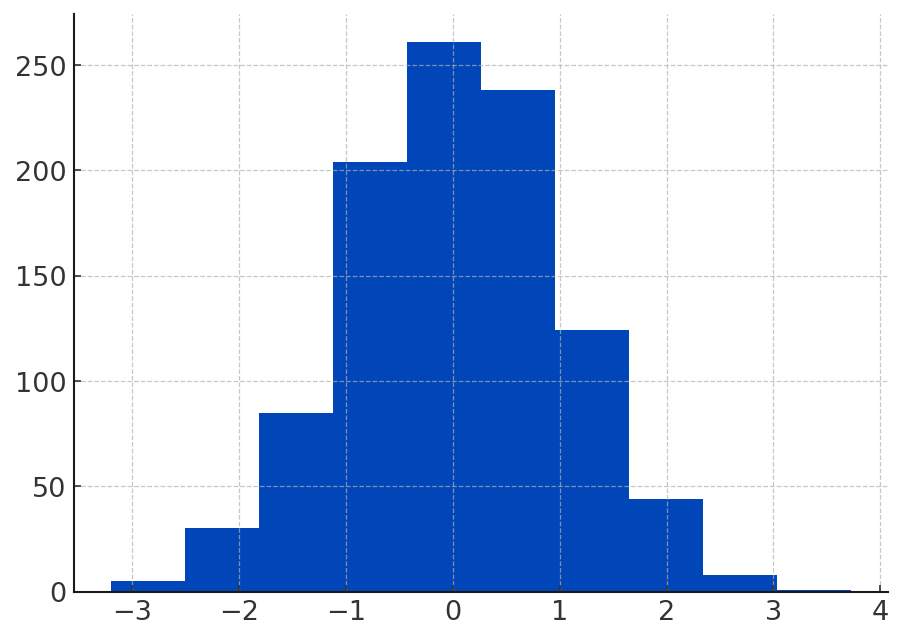

In [16]:
plt.hist(np.random.randn(1000));

Reset defaults.

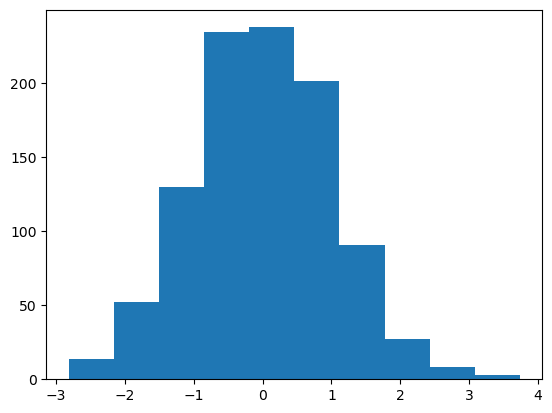

In [17]:
plt.rcdefaults()
plt.hist(np.random.randn(1000));

So, given all of the above and much more in the matplotlib docs on styling at https://matplotlib.org/stable/tutorials/introductory/customizing.html#sphx-glr-tutorials-introductory-customizing-py, we need to decide how to implement plot styling in hillmaker. Some random thoughts:

1. We could design some default plots and store the styling parameters in style sheet files. 
2. I've already added some additional style related input parameters to `make_week_hill_plot()` and will do same for any plot related scenario methods (which will likely just be wrappers around the module level `make_week_hill_plot()` function.
3. Power users can always make style changes after creating plot.

## Run hillmaker

In [18]:
ssu_stopdata = '../data/ShortStay.csv'
ssu_stops_df = pd.read_csv(ssu_stopdata, parse_dates=['InRoomTS','OutRoomTS'])
ssu_stops_df.info() # Check out the structure of the resulting DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 1.8+ MB


In [19]:
# Required inputs
scenario_name = 'ssu_1'
stops_df = ssu_stops_df
in_field_name = 'InRoomTS'
out_field_name = 'OutRoomTS'
start_date = '1996-01-01'
end_date = '1996-09-30'

# Optional inputs

cat_field_name = 'PatType'
verbosity = 1 # INFO level logging
output_path = './output'
bin_size_minutes = 60

s1 = hm.Scenario(scenario_name=scenario_name, 
                         stops_df=stops_df,
                         in_field=in_field_name,
                         out_field=out_field_name,
                         start_analysis_dt=start_date,
                         end_analysis_dt=end_date,
                         cat_field=cat_field_name,
                         output_path=Path('./output'),
                         verbosity=verbosity)

In [20]:
s1.make_hills()

2023-09-13 18:10:48,912 - hillmaker.bydatetime - INFO - min of intime: 1996-01-01 07:44:00
2023-09-13 18:10:48,913 - hillmaker.bydatetime - INFO - max of intime: 1996-09-29 19:51:00
2023-09-13 18:10:48,914 - hillmaker.bydatetime - INFO - min of outtime: 1996-01-01 08:50:00
2023-09-13 18:10:48,914 - hillmaker.bydatetime - INFO - max of outtime: 1996-09-29 20:15:00
2023-09-13 18:10:48,915 - hillmaker.bydatetime - INFO - start analysis: 1996-01-01, end analysis: 1996-09-30
2023-09-13 18:10:48,930 - hillmaker.bydatetime - INFO - min of entry time_bin = 7
2023-09-13 18:10:48,931 - hillmaker.bydatetime - INFO - max of exit time_bin = 6546 and num_bins=6553
2023-09-13 18:10:49,585 - hillmaker.bydatetime - INFO - cat IVT {'inner': 33019}
2023-09-13 18:10:49,630 - hillmaker.bydatetime - INFO - cat IVT num_arrivals_hm 33019 num_arrivals_stops 33019
2023-09-13 18:10:49,631 - hillmaker.bydatetime - INFO - cat IVT num_departures_hm 33019 num_departures_stops 33019
2023-09-13 18:10:49,635 - hillmake

In [21]:
s1.hills.keys()

dict_keys(['bydatetime', 'summaries', 'length_of_stay', 'settings'])

By default, the `get_summary_df` method will return the summary by category. It would be nice to design a stacked bar plot based on this dataframe. 

- the means would be the stacked bars
- for the percentiles, we need to use the summary df that is for the total (i.e. not by category).

In [22]:
s1.get_summary_df?

Signature:
s1.get_summary_df(
    flow_metric: str = 'occupancy',
    by_category: bool = True,
    stationary: bool = False,
)
Docstring:
Get summary dataframe

Parameters
----------
flow_metric : str
    Either of 'arrivals', 'departures', 'occupancy' ('a', 'd', and 'o' are sufficient).
    Default='occupancy'
by_category : bool
    Default=True corresponds to category specific statistics. A value of False gives overall statistics.
stationary : bool
    Default=False corresponds to the standard nonstationary statistics (i.e. by TOD and DOW)

Returns
-------
DataFrame
File:      ~/Documents/projects/hillmaker/src/hillmaker/scenario.py
Type:      method

In [23]:
occ_summary_cat_df = s1.get_summary_df()
occ_summary_cat_df

count  mean  min  max  \
PatType day_of_week dow_name bin_of_day bin_of_day_str                          
ART     0           Mon      0          00:00            40.0   0.0  0.0  0.0   
                             1          01:00            39.0   0.0  0.0  0.0   
                             2          02:00            39.0   0.0  0.0  0.0   
                             3          03:00            39.0   0.0  0.0  0.0   
                             4          04:00            39.0   0.0  0.0  0.0   
...                                                       ...   ...  ...  ...   
OTH     6           Sun      19         19:00            39.0   0.0  0.0  0.0   
                             20         20:00            39.0   0.0  0.0  0.0   
                             21         21:00            39.0   0.0  0.0  0.0   
                             22         22:00            39.0   0.0  0.0  0.0   
                             23         23:00            39.0   0.0  0.0  0.0   

                                                        stdev  sem  var   cv  \
PatType day_of_week dow_name bin_of_day bin_of_day_str                         
ART     0           Mon      0          00:00             0.0  0.0  0.0  0.0   
                             1          01:00             0.0  0.0  0.0  0.0   
                             2          02:00             0.0  0.0  0.0  0.0   
                             3          03:00             0.0  0.0  0.0  0.0   
                             4          04:00             0.0  0.0  0.0  0.0   
...                                                       ...  ...  ...  ...   
OTH     6           Sun      19         19:00             0.0  0.0  0.0  0.0   
                             20         20:00             0.0  0.0  0.0  0.0   
                             21         21:00             0.0  0.0  0.0  0.0   
                             22         22:00             0.0  0.0  0.0  0.0   
                             23         23:00             0.0  0.0  0.0  0.0   

                                                        skew  kurt  p25  p50  \
PatType day_of_week dow_name bin_of_day bin_of_day_str                         
ART     0           Mon      0          00:00            0.0   0.0  0.0  0.0   
                             1          01:00            0.0   0.0  0.0  0.0   
                             2          02:00            0.0   0.0  0.0  0.0   
                             3          03:00            0.0   0.0  0.0  0.0   
                             4          04:00            0.0   0.0  0.0  0.0   
...                                                      ...   ...  ...  ...   
OTH     6           Sun      19         19:00            0.0   0.0  0.0  0.0   
                             20         20:00            0.0   0.0  0.0  0.0   
                             21         21:00            0.0   0.0  0.0  0.0   
                             22         22:00            0.0   0.0  0.0  0.0   
                             23         23:00            0.0   0.0  0.0  0.0   

                                                        p75  p95  p99  
PatType day_of_week dow_name bin_of_day bin_of_day_str                 
ART     0           Mon      0          00:00           0.0  0.0  0.0  
                             1          01:00           0.0  0.0  0.0  
                             2          02:00           0.0  0.0  0.0  
                             3          03:00           0.0  0.0  0.0  
                             4          04:00           0.0  0.0  0.0  
...                                                     ...  ...  ...  
OTH     6           Sun      19         19:00           0.0  0.0  0.0  
                             20         20:00           0.0  0.0  0.0  
                             21         21:00           0.0  0.0  0.0  
                             22         22:00           0.0  0.0  0.0  
                             23         23:00           

To get the overall summary stats, we pass `by_category=False` when calling the `get_summary_df` method. 

**QUESTION** Of course, we could flip the default here. What do you think?

In [24]:
occ_summary_df = s1.get_summary_df(by_category=False)
occ_summary_df[25:40]

count       mean        min  \
day_of_week dow_name bin_of_day bin_of_day_str                                
1           Tue      1          01:00            39.0   0.202991   0.000000   
                     2          02:00            39.0   0.146581   0.000000   
                     3          03:00            39.0   0.096581   0.000000   
                     4          04:00            39.0   0.092308   0.000000   
                     5          05:00            39.0   0.175641   0.000000   
                     6          06:00            39.0   2.454274   1.000000   
                     7          07:00            39.0  19.416239  12.666667   
                     8          08:00            39.0  27.877778  20.333333   
                     9          09:00            39.0  22.536325  10.816667   
                     10         10:00            39.0  32.497436  22.733333   
                     11         11:00            39.0  38.423077  27.350000   
                     12         12:00            39.0  39.510684  25.400000   
                     13         13:00            39.0  36.269231  25.350000   
                     14         14:00            39.0  31.405128  23.616667   
                     15         15:00            39.0  27.542308  19.583333   

                                                      max     stdev       sem  \
day_of_week dow_name bin_of_day bin_of_day_str                                  
1           Tue      1          01:00            1.333333  0.375022  0.060052   
                     2          02:00            1.466667  0.323703  0.051834   
                     3          03:00            0.750000  0.219755  0.035189   
                     4          04:00            1.000000  0.227491  0.036428   
                     5          05:00            1.300000  0.334992  0.053642   
                     6          06:00            5.000000  1.077486  0.172536   
                     7          07:00           24.083333  2.559290  0.409814   
                     8          08:00           33.283333  3.198180  0.512119   
                     9          09:00           30.116667  4.187706  0.670570   
                     10         10:00           39.150000  4.065801  0.651049   
                     11         11:00           49.066667  4.710699  0.754315   
                     12         12:00           49.666667  5.157644  0.825884   
                     13         13:00           42.983333  5.319737  0.851840   
                     14         14:00           38.450000  3.858078  0.617787   
                     15         15:00           38.216667  3.890403  0.622963   

                                                      var        cv      skew  \
day_of_week dow_name bin_of_day bin_of_day_str                                  
1           Tue      1          01:00            0.140641  1.847476  1.931038   
                     2          02:00            0.104783  2.208350  2.610424   
                     3          03:00            0.048292  2.275336  2.126966   
                     4          04:00            0.051752  2.464485  2.676122   
                     5          05:00            0.112220  1.907257  1.878066   
                     6          06:00            1.160975  0.439024  0.820301   
                     7          07:00            6.549963  0.131812 -0.426090   
                     8          08:00           10.228353  0.114721 -0.647689   
                     9          09:00           17.536884  0.185820 -0.672795   
                     10         10:00           16.530739  0.125111 -0.450546   
                     11         11:00           22.190682  0.122601 -0.535508   
                     12         12:00           26.601294  0.130538 -0.544897   
                     13         13:00           28.299599  0.146674 -0.631588   
                     14         14:00           14.884768  0.122849 -0.064790   
                     15       

## Changing sort order of summary df

It would be nice if user could select which DOW appears at the left side of the plot. We need to be able to sort the summary df using a custom sort order.

Seems doable using the `key` parameter of `sort_values` where `key` can be a callable. Be 

In [25]:
# Be careful, sorting only by day_of_week doesn't maintain secondary sort order by bin_of_day
occ_summary_df.sort_values(by=['day_of_week', 'bin_of_day'])

count      mean  min  \
day_of_week dow_name bin_of_day bin_of_day_str                         
0           Mon      0          00:00            40.0  0.255000  0.0   
                     1          01:00            39.0  0.211966  0.0   
                     2          02:00            39.0  0.209402  0.0   
                     3          03:00            39.0  0.194872  0.0   
                     4          04:00            39.0  0.114103  0.0   
...                                               ...       ...  ...   
6           Sun      19         19:00            39.0  0.535470  0.0   
                     20         20:00            39.0  0.489316  0.0   
                     21         21:00            39.0  0.433761  0.0   
                     22         22:00            39.0  0.368376  0.0   
                     23         23:00            39.0  0.355983  0.0   

                                                     max     stdev       sem  \
day_of_week dow_name bin_of_day bin_of_day_str                                 
0           Mon      0          00:00           1.833333  0.418453  0.066163   
                     1          01:00           1.600000  0.384266  0.061532   
                     2          02:00           0.916667  0.335340  0.053697   
                     3          03:00           1.133333  0.334016  0.053485   
                     4          04:00           1.000000  0.258610  0.041411   
...                                                  ...       ...       ...   
6           Sun      19         19:00           3.266667  0.747004  0.119616   
                     20         20:00           2.000000  0.596168  0.095463   
                     21         21:00           1.966667  0.463310  0.074189   
                     22         22:00           2.066667  0.510315  0.081716   
                     23         23:00           2.083333  0.493207  0.078976   

                                                     var        cv      skew  \
day_of_week dow_name bin_of_day bin_of_day_str                                 
0           Mon      0          00:00           0.175103  1.640991  2.024153   
                     1          01:00           0.147660  1.812866  2.006676   
                     2          02:00           0.112453  1.601421  1.164433   
                     3          03:00           0.111567  1.714029  1.545051   
                     4          04:00           0.066879  2.266471  2.307284   
...                                                  ...       ...       ...   
6           Sun      19         19:00           0.558014  1.395043  1.813045   
                     20         20:00           0.355416  1.218370  1.119442   
                     21         21:00           0.214656  1.068124  1.194987   
                     22         22:00           0.260421  1.385309  1.608689   
                     23         23:00           0.243253  1.385478  1.578062   

                                                    kurt  p25       p50  \
day_of_week dow_name bin_of_day bin_of_day_str                            
0           Mon      0          00:00           4.603107  0.0  0.000000   
                     1          01:00           3.737138  0.0  0.000000   
                     2          02:00          -0.348937  0.0  0.000000   
                     3          03:00           1.049713  0.0  0.000000   
                     4          04:00           4.487256  0.0  0.000000   
...                                                  ...  ...       ...   
6           Sun      19         19:00           3.776304  0.0  0.150000   
                     20         20:00           0.457068  0.0  0.250000   
                     21         21:00           1.781882  0.0  0.333333   
                     22         22:00           2.409985  0.0  0.083333   
                     23         23:00           2.748971  0.0  0.000000   

                                                     

This is the basic idea I ended up implementing in hillmaker. Hillmaker creates a new plot day of week field (temporarily).

In [26]:
def plot_dow(dow, first_dow):
    if dow < first_dow:
        return dow + 7
    else:
        return dow

first_dow = 6
occ_summary_df_plot = occ_summary_df.copy()
occ_summary_df_plot.reset_index(inplace=True, drop=False)
occ_summary_df_plot['plot_dow'] = occ_summary_df_plot['day_of_week'].map(lambda d: plot_dow(d, first_dow))

In [27]:
occ_summary_df_plot.sort_values(by=['plot_dow', 'bin_of_day'])

,day_of_week,dow_name,bin_of_day,bin_of_day_str,count,mean,min,max,stdev,sem,var,cv,skew,kurt,p25,p50,p75,p95,p99,plot_dow
144,6,Sun,0,00:00,39.0,0.250000,0.0,1.666667,0.466557,0.074709,0.217675,1.866228,1.837737,2.236390,0.0,0.000000,0.225000,1.340000,1.565333,6
145,6,Sun,1,01:00,39.0,0.138889,0.0,1.683333,0.329968,0.052837,0.108879,2.375772,3.234425,12.381305,0.0,0.000000,0.000000,0.663333,1.341333,6
146,6,Sun,2,02:00,39.0,0.211111,0.0,1.416667,0.391622,0.062710,0.153367,1.855049,1.870809,2.664552,0.0,0.000000,0.283333,0.990000,1.391333,6
147,6,Sun,3,03:00,39.0,0.176068,0.0,1.000000,0.296219,0.047433,0.087746,1.682407,1.570781,1.276268,0.0,0.000000,0.283333,0.841667,0.968333,6
148,6,Sun,4,04:00,39.0,0.182479,0.0,1.583333,0.362334,0.058020,0.131286,1.985623,2.413378,5.864026,0.0,0.000000,0.158333,1.008333,1.393333,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,5,Sat,19,19:00,39.0,0.773504,0.0,2.966667,0.773555,0.123868,0.598388,1.000066,0.773200,0.001678,0.0,0.583333,1.316667,2.000000,2.656333,12
140,5,Sat,20,20:00,39.0,0.599145,0.0,2.000000,0.598621,0.095856,0.358347,0.999125,0.806826,-0.210748,0.0,0.500000,0.841667,1.698333,1.993667,12
141,5,Sat,21,21:00,39.0,0.573932,0.0,2.550000,0.699674,0.112038,0.489544,1.219090,1.250096,0.720307,0.0,0.333333,0.866667,2.006667,2.366333,12
142,5,Sat,22,22:00,39.0,0.340598,0.0,1.500000,0.423830,0.067867,0.179632,1.244368,1.294896,0.939911,0.0,0.250000,0.550000,1.301667,1.430333,12


## Plotting

I created a module level function called `make_week_hill_plot` that just focuses on making the weekly plot. I added a bunch of functionality to make it easier for user to customize the plot contents and style.

- `plot_style` can be specified. Right now the default is 'ggplot' but we can change that.
- Figure size can be set via `figsize=`
- The bar colors can be set via `bar_color_mean=`
- which percentiles plotted and their color and linestyles can be specified via `percentiles`, `pctile_color`, `pctile_linestyle`, and `pctile_linewidth`.
- The super title can be set with `suptitle=`
- Additional style parameters related to `suptitle` can be specified with the `suptitle_properties=` dictionary
- Similar input args are available for the `title`.
- Legend properties can be set via `legend_properties=` dictionary
- A capacity line and its color can be set via `cap=` and `cap_color=`


### Styling issues

Certainly we can improve the styles and style management. For example, it would be nice to have a way to have application and session level style defaults. Need to think through how to do this. For now, there are enough input parameters to create relatively customized plots.

### Plot examples

In the following examples I start by showing the global plotting functions and then the scenario methods. Totally open to suggestions for improvements.

In [28]:
plot1 = make_week_hill_plot(summary_df=occ_summary_df, metric='occupancy',
                        bin_size_minutes=60,
                        cap=52,
                        cap_color='green',
                        plot_style='ggplot',
                        figsize=(15, 10),
                        bar_color_mean='steelblue',
                        percentiles=(0.95, 0.75),
                        pctile_color=('black', 'grey'),
                        pctile_linestyle=('-', '-.'),
                        pctile_linewidth=(.75, .75), 
                        suptitle='Weekly occupancy summary',
                        suptitle_properties={'x': 0.125, 'y': 0.95, 'horizontalalignment': 'left', 'verticalalignment': 'top', 'fontsize': 16},
                        title='Overall occupancy',
                        title_properties={'loc': 'left', 'style': 'italic'},
                        legend_properties={'loc': 'best', 'frameon': True, 'facecolor': 'w'},
                        xlabel='Hour',
                        ylabel='Patients',
                        first_dow='mon',
                        scenario_name='plot_test', 
                        export_path='./output')

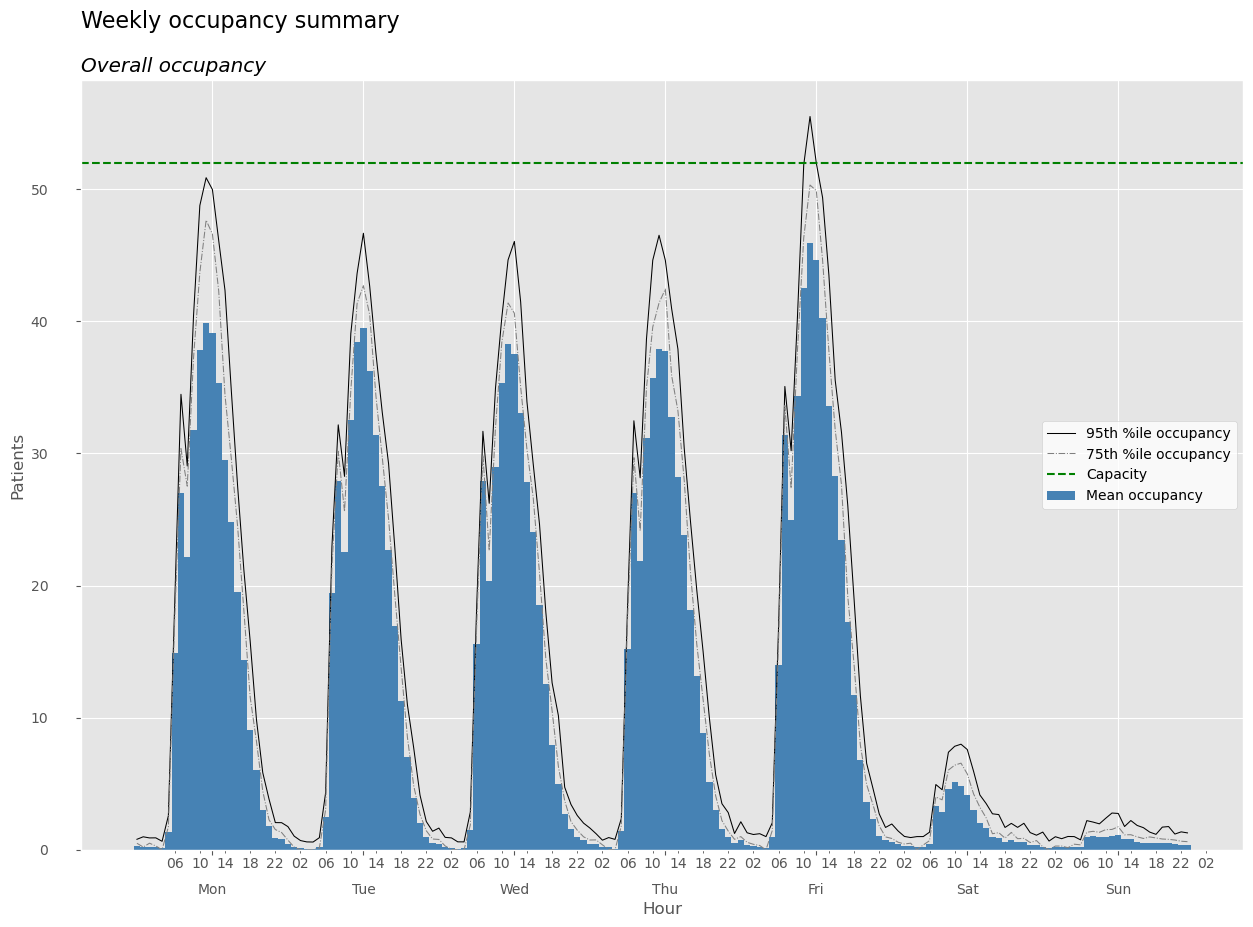

In [29]:
plot1

The only required argument is the first. Defaults exist for the rest.

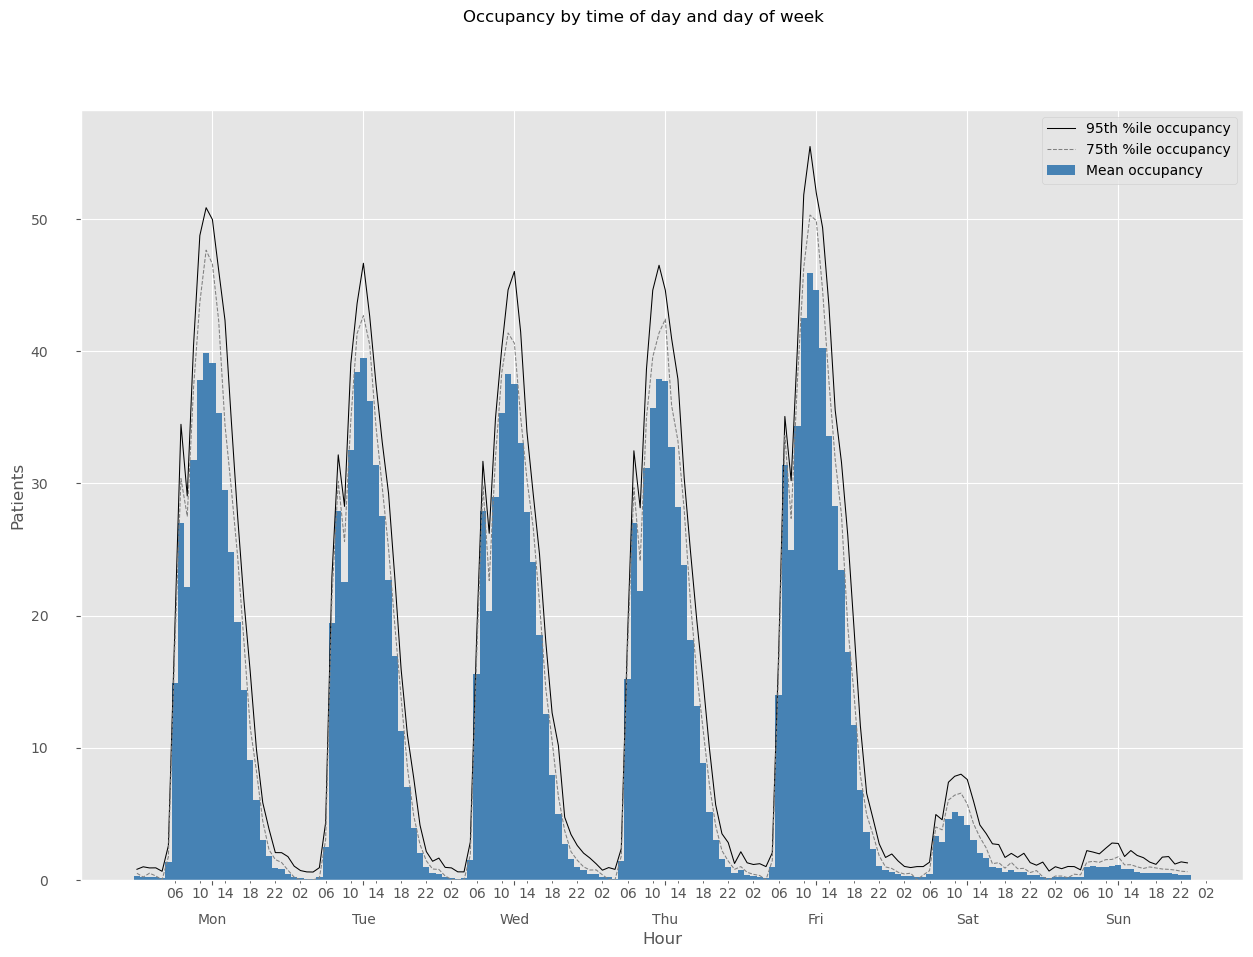

In [30]:
plot2 = make_week_hill_plot(summary_df=occ_summary_df)
plot2

All the plot styling in the previos plot was set within a context manager in `make_week_hill_plot()`. So, seems like style should now revert to default. But maybe notebooks are funny.

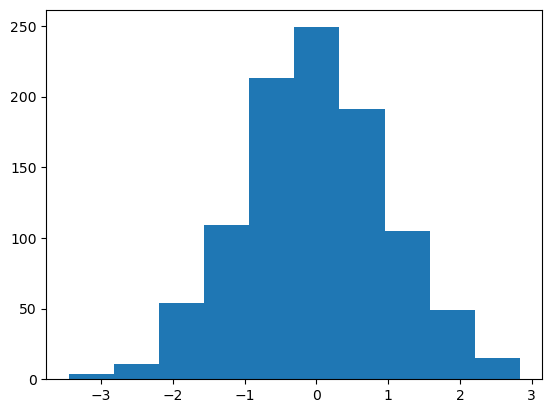

In [31]:
plt.hist(np.random.randn(1000));

Yep, it's still the default. Great, the context manager code is working.

Now change the first dow to Sunday.

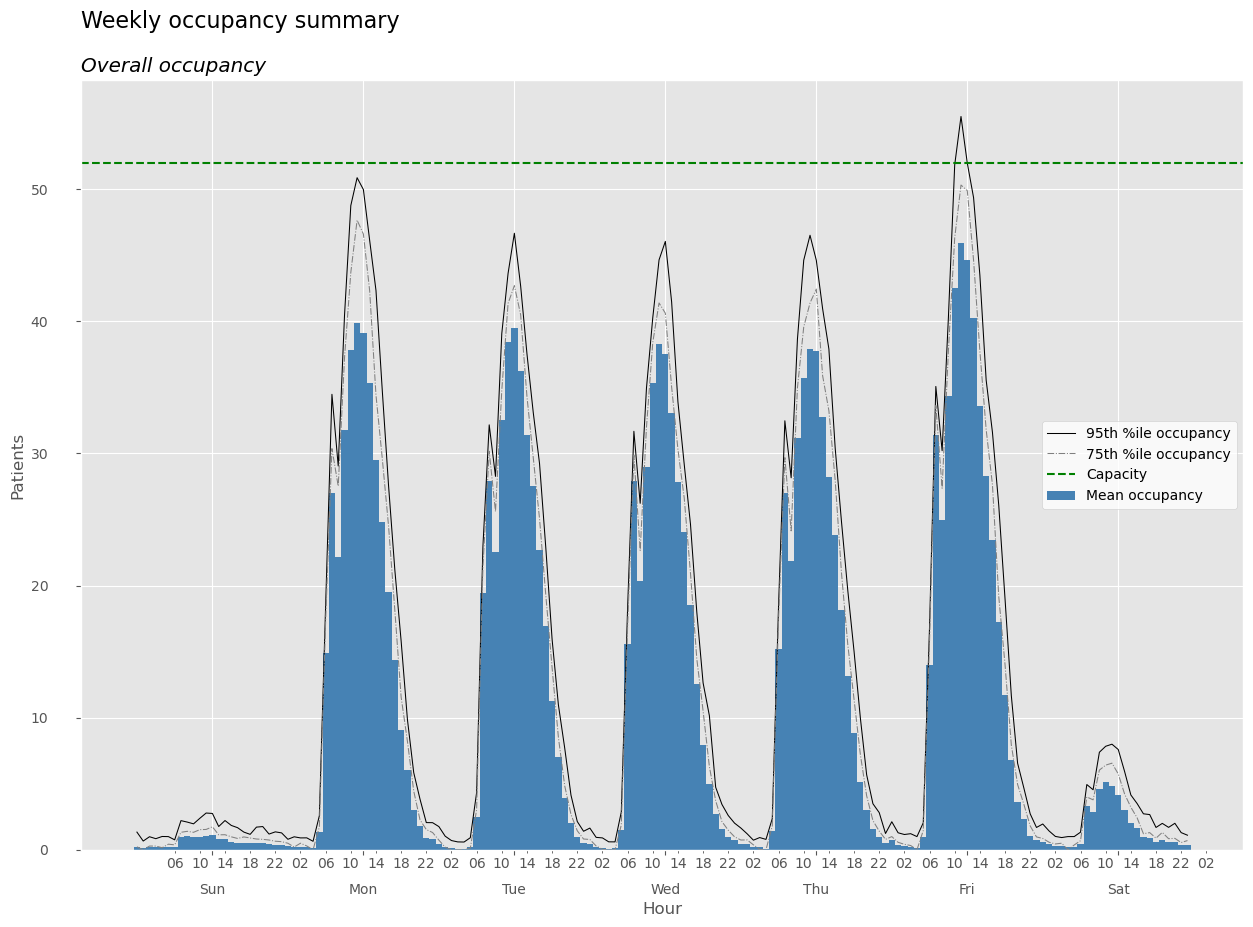

In [32]:
plot3 = make_week_hill_plot(summary_df=occ_summary_df, metric='occupancy',
                        bin_size_minutes=60,
                        cap=52,
                        cap_color='green',
                        plot_style='ggplot',
                        figsize=(15, 10),
                        bar_color_mean='steelblue',
                        percentiles=[0.95, 0.75],
                        pctile_color=['black', 'grey'],
                        pctile_linestyle=['-', '-.'],
                        pctile_linewidth=[.75, .75], 
                        suptitle='Weekly occupancy summary',
                        suptitle_properties={'x': 0.125, 'y': 0.95, 'horizontalalignment': 'left', 'verticalalignment': 'top', 'fontsize': 16},
                        title='Overall occupancy',
                        title_properties={'loc': 'left', 'style': 'italic'},
                        legend_properties={'loc': 'best', 'frameon': True, 'facecolor': 'w'},
                        xlabel='Hour',
                        ylabel='Patients',
                        first_dow='sun',
                        scenario_name='plot_test', 
                        export_path='./output')

plot3

Make sure cycler working with a single percentile

`pctile_color=('black')` leads to error where cycler addition doesn't work as it interprets 'black' as five separate color codes to be cycled through.

If I change to `pct_color=('k')`, I get a `TypeError: 'float' object is not iterable`.

Ah, the issue is with tuples containing a single value. Need the trailing comma. Better, just use lists.

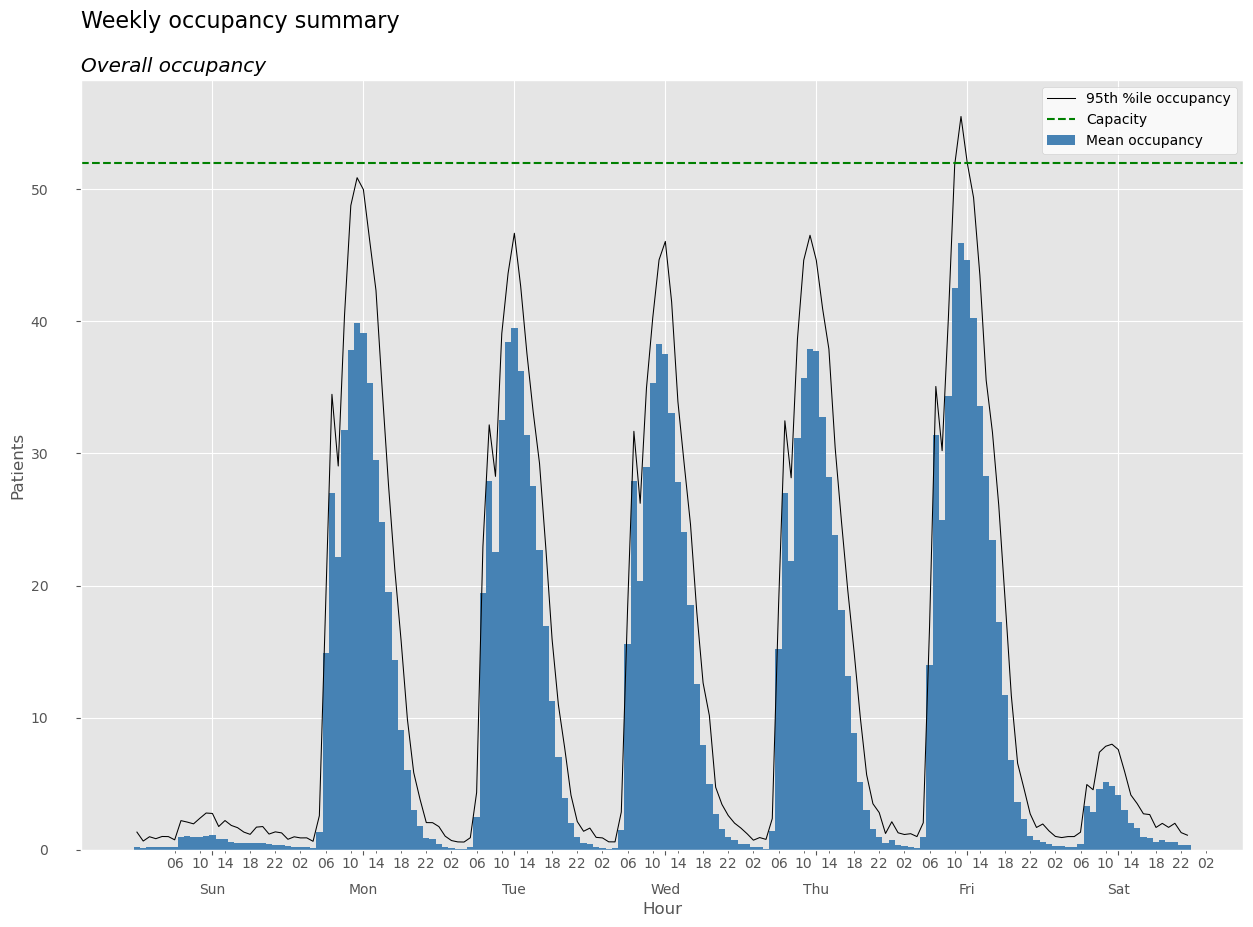

In [33]:
plot4 = make_week_hill_plot(summary_df=occ_summary_df, metric='occupancy',
                        bin_size_minutes=60,
                        cap=52,
                        cap_color='green',
                        plot_style='ggplot',
                        figsize=(15, 10),
                        bar_color_mean='steelblue',
                        percentiles=[0.95],
                        pctile_color=['k'],
                        pctile_linestyle=['-'],
                        pctile_linewidth=[.75], 
                        suptitle='Weekly occupancy summary',
                        suptitle_properties={'x': 0.125, 'y': 0.95, 'horizontalalignment': 'left', 'verticalalignment': 'top', 'fontsize': 16},
                        title='Overall occupancy',
                        title_properties={'loc': 'left', 'style': 'italic'},
                        legend_properties={'loc': 'best', 'frameon': True, 'facecolor': 'w'},
                        xlabel='Hour',
                        ylabel='Patients',
                        first_dow='sun',
                        scenario_name='plot_test', 
                        export_path='./output')

plot4

## OO version of weekly plot

I added a `make_weekly_plot` method to the scenario class which is mostly just a wrapper for `make_weekly_hill_plot`. Some of the inputs to `make_weekly_hill_plot` are automatically grabbed from the scenario object.

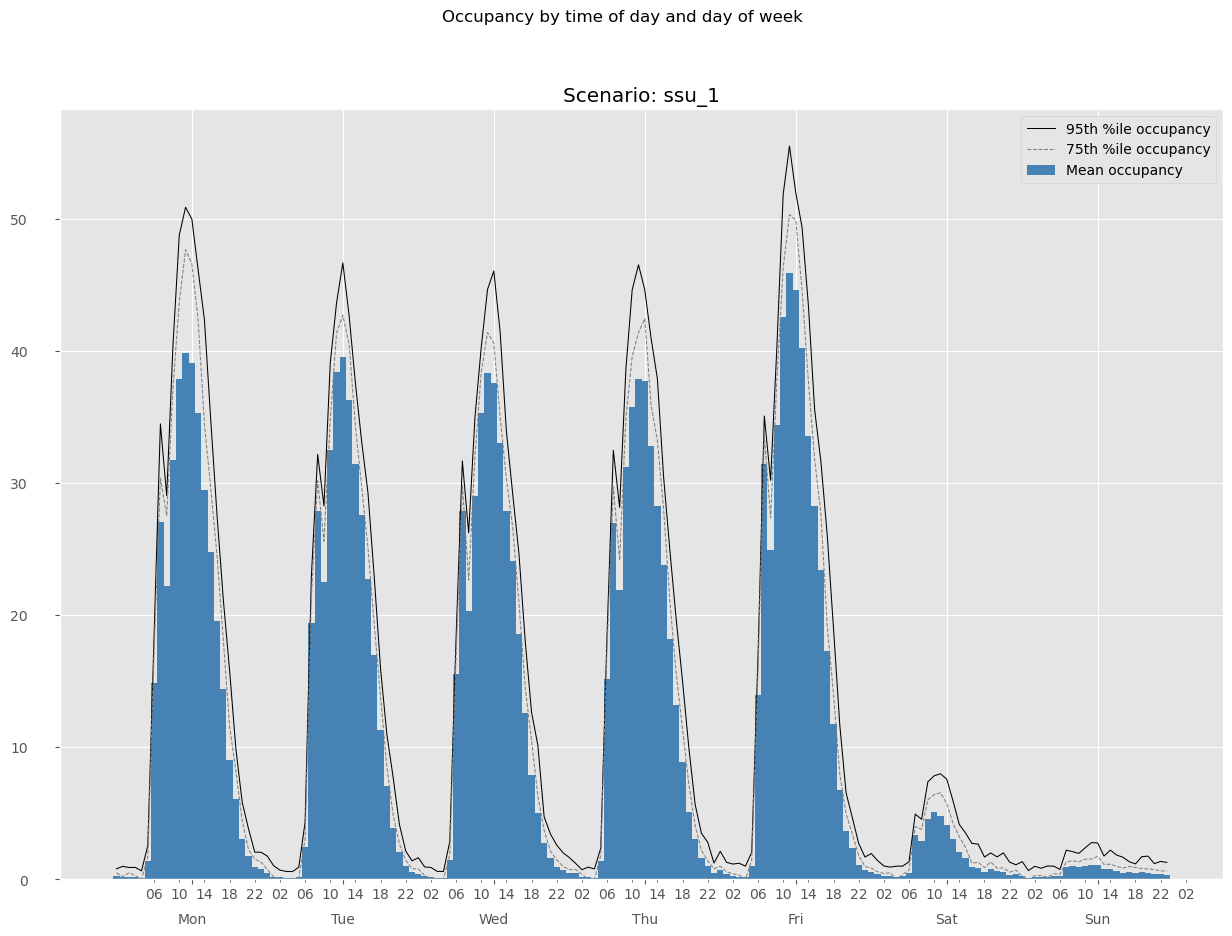

In [34]:
s1.make_weekly_plot()

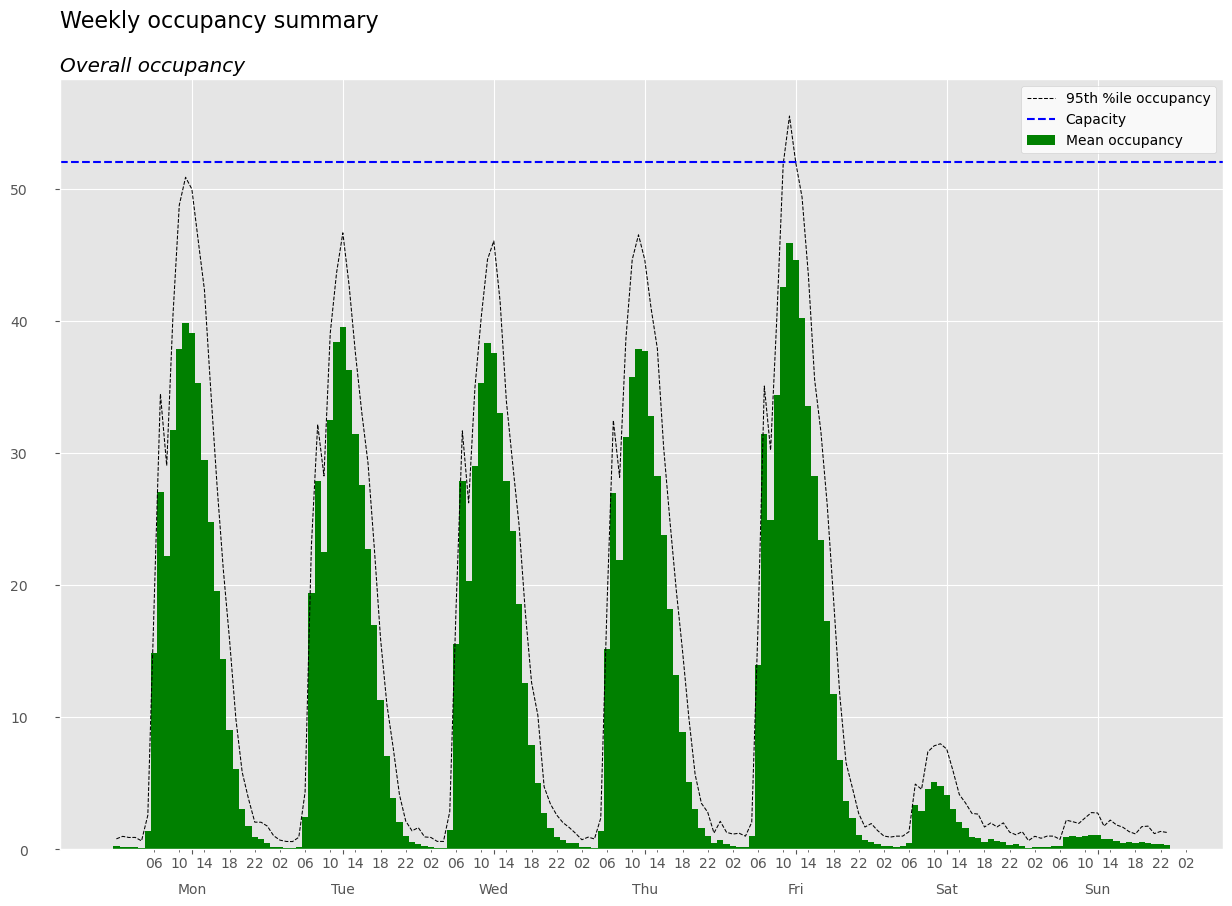

In [35]:
s1.make_weekly_plot(bar_color_mean='green',
                    cap=52,
                    cap_color='blue',
                    percentiles=[0.95],
                    pctile_color=['k'],
                    pctile_linestyle=['--'],
                    pctile_linewidth=[.75],
                    suptitle='Weekly occupancy summary',
                    suptitle_properties={'x': 0.125, 'y': 0.95, 'horizontalalignment': 'left', 'verticalalignment': 'top', 'fontsize': 16},
                    title='Overall occupancy',
                    title_properties={'loc': 'left', 'style': 'italic'},
                    legend_properties={'loc': 'best', 'frameon': True, 'facecolor': 'w'},
                    xlabel='')

## Daily plots

Copied `make_week_hill_plot` to `make_daily_hill_plot` and tweaked logic for daily plot. Then created scenario wrapper method analogous to the weekly method.

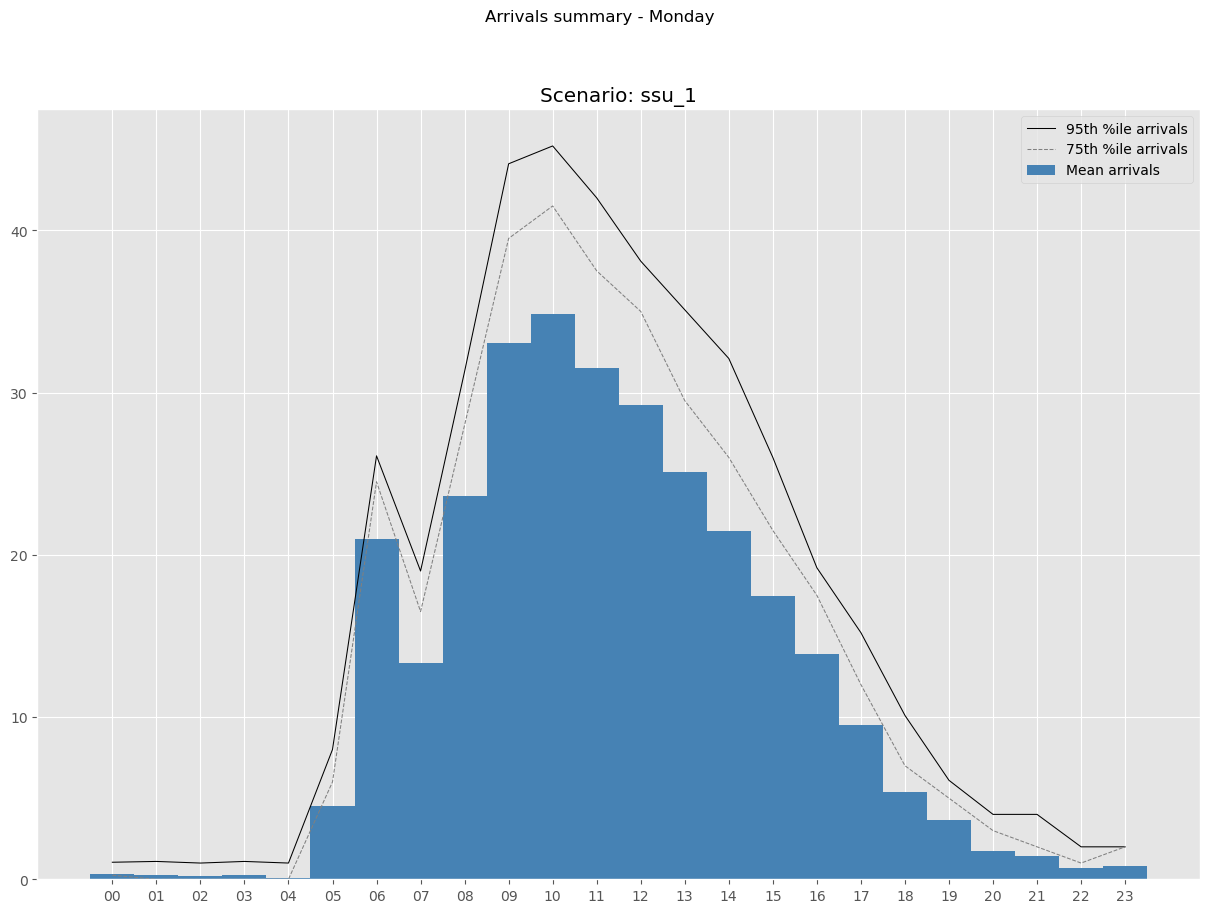

In [36]:
s1.make_daily_plot('mon', metric='arrivals')

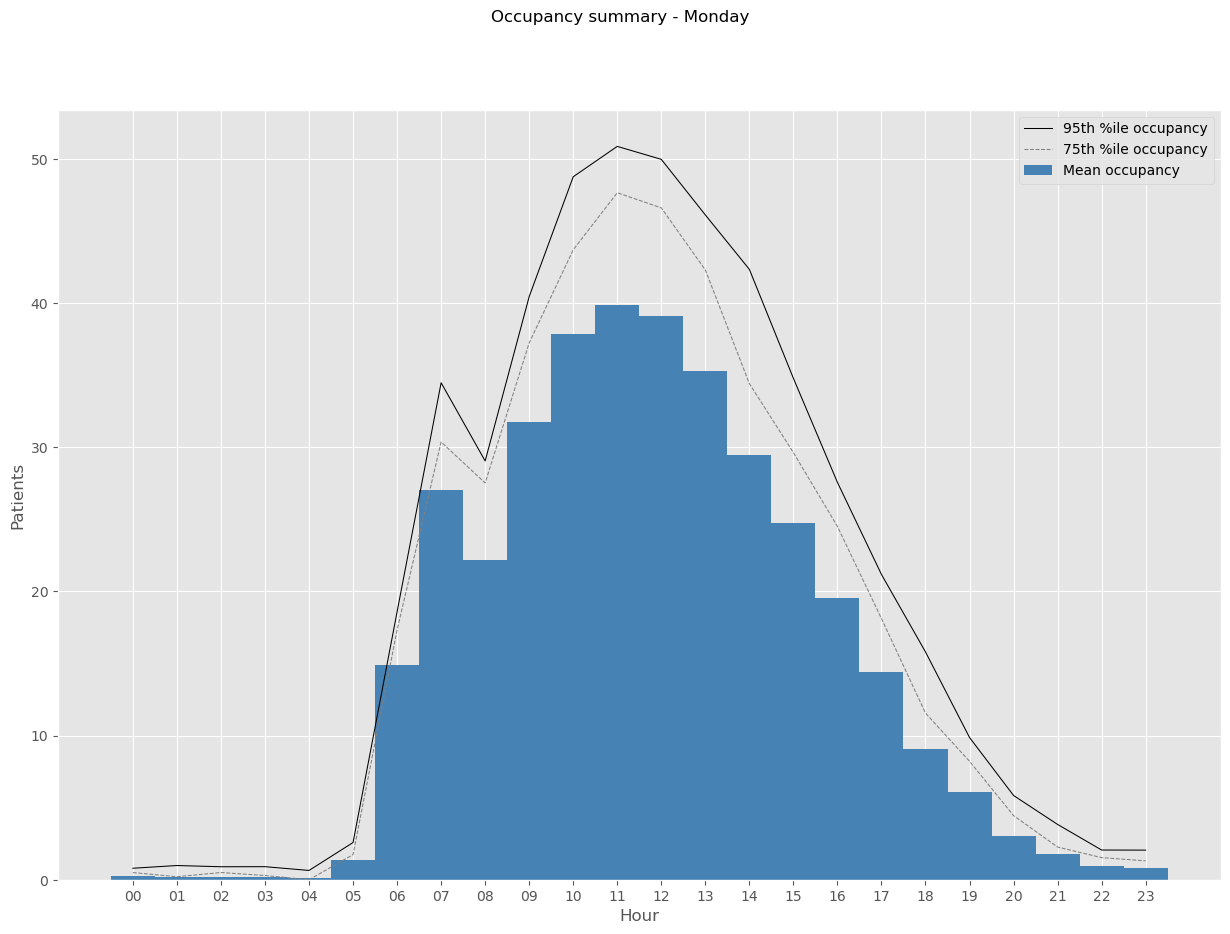

In [37]:
mon_plot = make_daily_hill_plot(summary_df=occ_summary_df, day_of_week='mon')
mon_plot

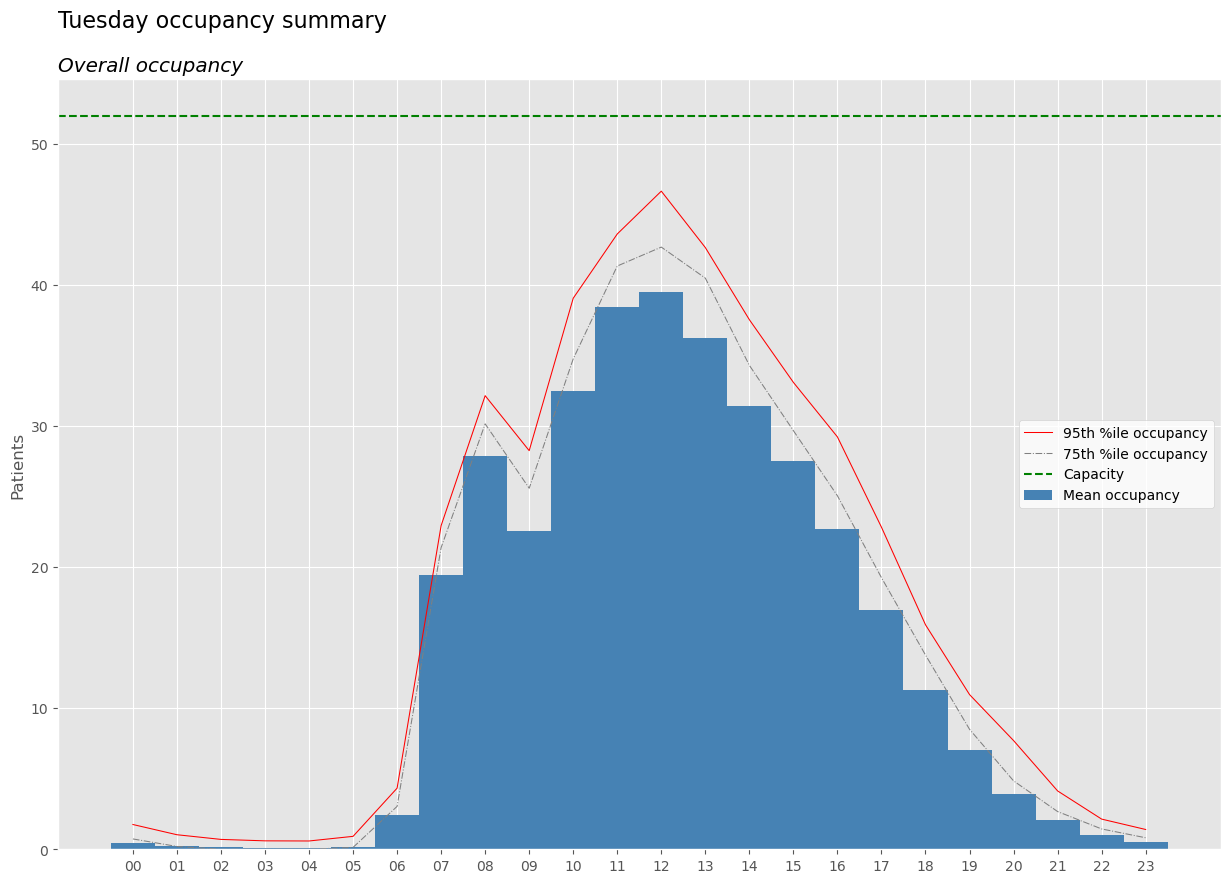

In [38]:
tue_plot = make_daily_hill_plot(summary_df=occ_summary_df, day_of_week='tue', metric='occupancy',
                        bin_size_minutes=60,
                        cap=52,
                        cap_color='green',
                        plot_style='ggplot',
                        figsize=(15, 10),
                        bar_color_mean='steelblue',
                        percentiles=[0.95, 0.75],
                        pctile_color=['red', 'grey'],
                        pctile_linestyle=['-', '-.'],
                        pctile_linewidth=[.75, .75], 
                        suptitle='Tuesday occupancy summary',
                        suptitle_properties={'x': 0.125, 'y': 0.95, 'horizontalalignment': 'left', 'verticalalignment': 'top', 'fontsize': 16},
                        title='Overall occupancy',
                        title_properties={'loc': 'left', 'style': 'italic'},
                        legend_properties={'loc': 'best', 'frameon': True, 'facecolor': 'w'},
                        xlabel='',
                        ylabel='Patients',
                        scenario_name='plot_test', 
                        export_path='./output')

tue_plot

Just showing that the default plots were not created. Also, notice that there's a 'length_of_stay' key.

In [39]:
s1.hills.keys()

dict_keys(['bydatetime', 'summaries', 'length_of_stay', 'settings'])

In [40]:
s1.hills['length_of_stay'].keys()

dict_keys(['los_bycat_stats', 'los_stats', 'los_histos'])

In [41]:
s1.hills['length_of_stay']['los_bycat_stats']

,count,mean,min,max,stdev,cv,skew,p50,p75,p95,p99
PatType,,,,,,,,,,,
ART,5738,1.5,0.5,2.5,0.4,0.3,0.4,1.4,1.8,2.2,2.4
CAT,10641,1.0,0.1,6.0,0.6,0.5,2.1,1.0,1.2,2.1,3.1
IVT,33019,1.1,0.0,10.9,0.7,0.6,2.9,1.0,1.4,2.3,3.8
MYE,6447,1.4,0.5,2.5,0.4,0.3,0.4,1.4,1.7,2.2,2.4
OTH,3747,1.5,1.0,2.5,0.3,0.2,0.5,1.4,1.8,2.1,2.3


In [42]:
s1.hills['length_of_stay']['los_stats']

,count,mean,min,max,stdev,cv,skew,p50,p75,p95,p99
all,59592,1.2,0.0,10.9,0.6,0.5,2.3,1.1,1.5,2.2,3.4


In [43]:
plot = s1.hills['length_of_stay']['los_histos']
plot.fig



AttributeError: 'Figure' object has no attribute 'fig'

In [ ]:
plot.